In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from scipy.fftpack import dct, idct
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
image = cv2.imread('Summer Farewell.jpg', cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('December Special.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (512,512))
image = image.astype(np.float64)

In [3]:
reconstructed_img_norequant = np.zeros_like(image)
reconstructed_img_lossy = np.zeros_like(image)
reconstructed_img_lossless = np.zeros_like(image)

In [4]:
reconstructed_img_classical_norequant = np.zeros_like(image)
reconstructed_img_classical_lossy = np.zeros_like(image)
reconstructed_img_classical_lossless = np.zeros_like(image)

In [5]:
def classical_dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def classical_idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

In [6]:
def DCT_mat(N):
    Mat = np.zeros((N, N))
    for k in range(N):
        for n in range (N):
            alpha = np.sqrt(1/N) if k == 0 else np.sqrt(2/N)
            Mat[k,n] = alpha * np.cos(np.pi * (n + 0.5) * k / N)

    return Mat

In [7]:
def compute_metrics(original, resconstructions):
    result = []
    original_int8 = original.astype(np.uint8)
    for name, imgs in resconstructions.items():
        if name == "Original":
            continue

        img_int8 = imgs.astype(np.uint8)
        psnr_val = psnr(original_int8, img_int8, data_range=255)
        ssim_val = ssim(original_int8, img_int8, data_range=255)
        nonzero_ori = np.count_nonzero(original_int8)
        nonzero_recons = np.count_nonzero(img_int8)
        compression_ratio = nonzero_ori / nonzero_recons if nonzero_recons != 0 else 0
        result.append({
            "Image": name,
            "PSNR": psnr_val,
            "SSIM":ssim_val,
            "Compression Ratio": compression_ratio
        })

    return pd.DataFrame(result)

In [8]:
DCT8x8 = DCT_mat(64)

In [9]:
IDCT8x8 = DCT8x8.T

In [10]:
quantization_mat = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]]
    , dtype=np.float64)

In [11]:
nonzeros_qdct_lossy = 0
nonzeros_cdct_lossy = 0
original_nonzero = np.count_nonzero(image)

for i in range(0, 512, 8):
    for j in range (0, 512, 8):
        block = image[i:i+8, j:j+8]

        flat_block = block.flatten()
        norm_block = flat_block / np.linalg.norm(flat_block)

        state_vector = Statevector(norm_block)
        qdct_out = state_vector.evolve(Operator(DCT8x8)).data
        qdct_2d = np.real(qdct_out).reshape(8, 8)

        recons_norequant = qdct_2d.copy()
        lossless_quant = qdct_2d / quantization_mat
        lossy_quant = np.round(qdct_2d/quantization_mat)

        lossless_recons = lossless_quant * quantization_mat
        lossy_recons = lossy_quant * quantization_mat

        for recons, out_img in zip([recons_norequant, lossy_recons, lossless_recons], [reconstructed_img_norequant, reconstructed_img_lossy, reconstructed_img_lossless]):
            flat_dequant = recons.flatten()
            norm_dequant = np.linalg.norm(flat_dequant)
            norm_dequant = flat_dequant if norm_dequant == 0 else flat_dequant / norm_dequant

            sv_recons = Statevector(norm_dequant)
            idct_out = sv_recons.evolve(Operator(IDCT8x8)).data
            recons_block = np.real(idct_out).reshape(8,8)

            min_val = recons_block.min()
            max_val = recons_block.max()

            scaled_val = 255 * (recons_block - min_val) / (max_val - min_val + 1e-8)
            out_img[i:i+8, j:j+8] = np.clip(scaled_val, 0, 255)

        cdct = classical_dct2(block)
        classical_recons_norequant = classical_idct2(cdct)
        classical_quant_lossless = cdct / quantization_mat
        classical_quant_lossy = np.round(cdct / quantization_mat)

        classical_lossless_recons = classical_idct2(classical_quant_lossless * quantization_mat)
        classical_lossy_recons = classical_idct2(classical_quant_lossy * quantization_mat)

        for recons, out_img in zip([classical_recons_norequant, classical_lossless_recons, classical_lossy_recons], [reconstructed_img_classical_norequant, reconstructed_img_classical_lossless, reconstructed_img_classical_lossy]):
            min_val = recons.min()
            max_val = recons.max()
            scaled_val = 255 * (recons - min_val) / (max_val - min_val + 1e-8)
            out_img[i:i+8, j:j+8] = np.clip(scaled_val, 0, 255)


In [12]:
reconstructed_imgs = [image, reconstructed_img_lossless, reconstructed_img_classical_lossless, reconstructed_img_classical_lossy, reconstructed_img_lossy, reconstructed_img_classical_norequant, reconstructed_img_norequant]
result_imgs = [img.astype(np.uint8) for img in reconstructed_imgs]

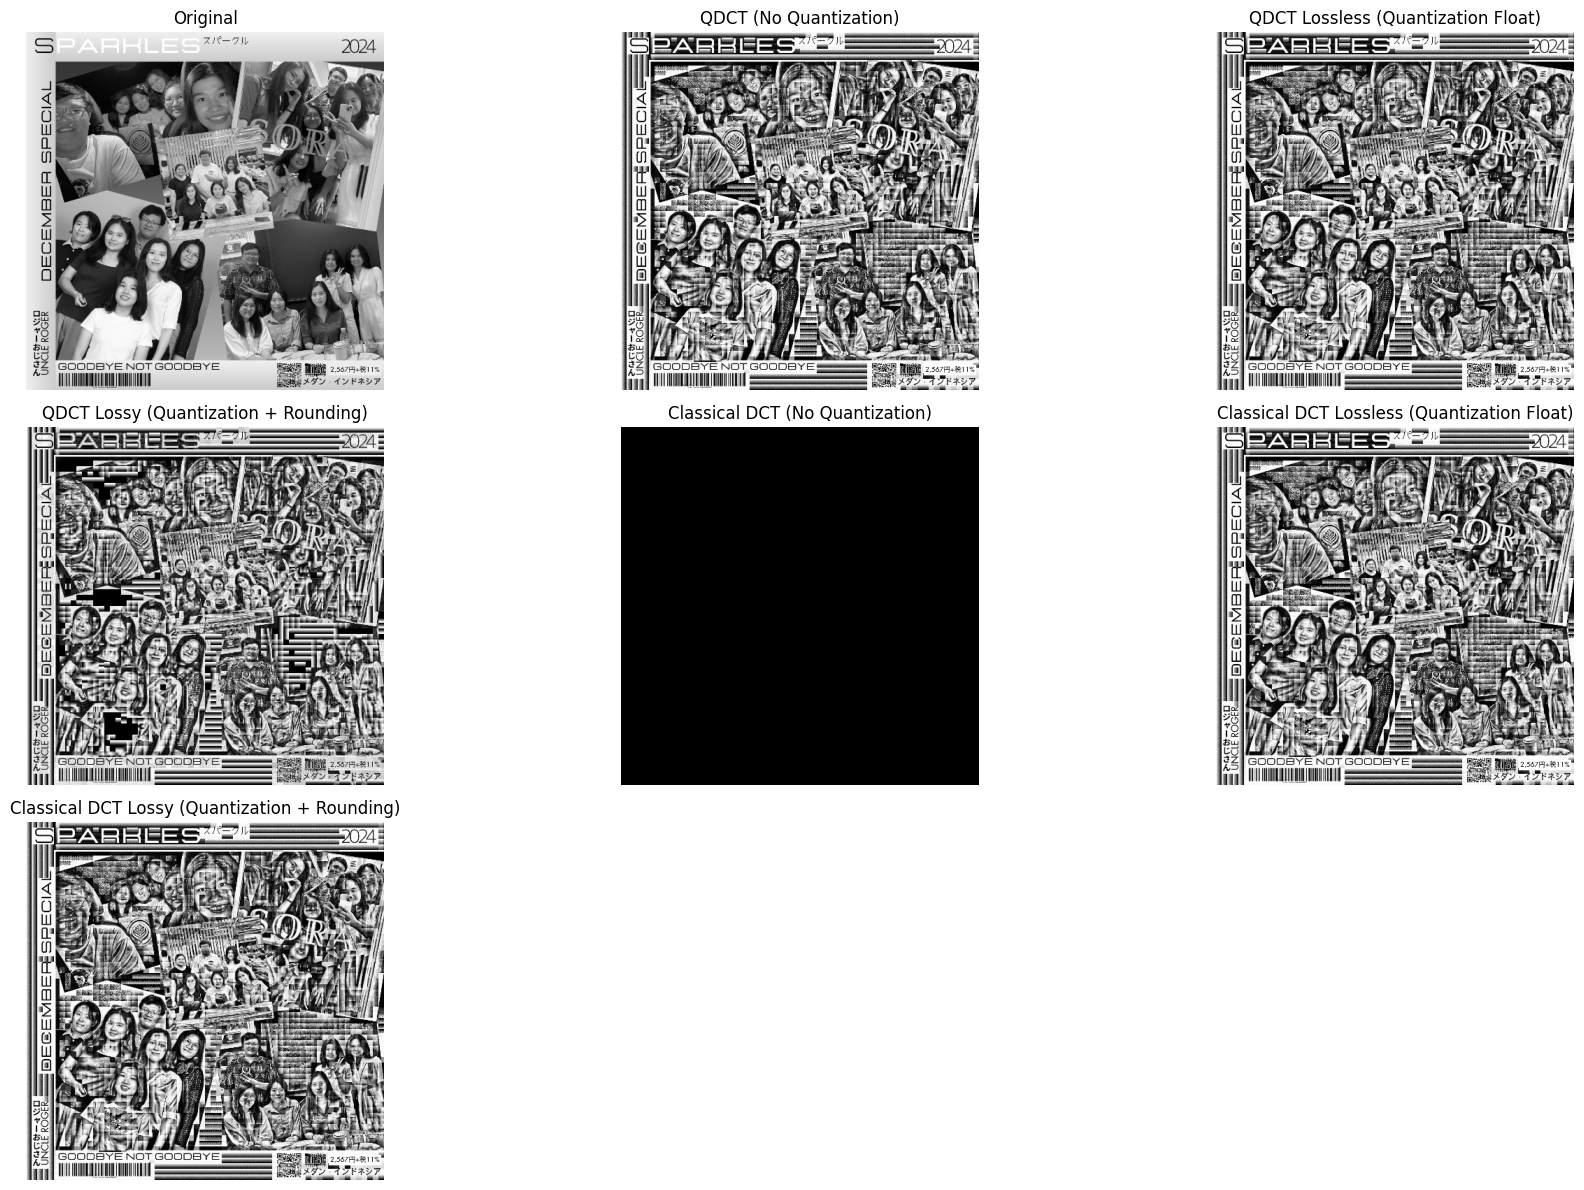

In [13]:
titles = [
    "Original",
    "QDCT (No Quantization)",
    "QDCT Lossless (Quantization Float)",
    "QDCT Lossy (Quantization + Rounding)",
    "Classical DCT (No Quantization)",
    "Classical DCT Lossless (Quantization Float)",
    "Classical DCT Lossy (Quantization + Rounding)"
]

plt.figure(figsize=(18, 12))
for idx, (title, img) in enumerate(zip(titles, result_imgs)):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
images_dict = {
    "Original": result_imgs[0],
    "QDCT (No Quantization)": result_imgs[6],
    "QDCT Lossless (Quantization Float)": result_imgs[1],
    "QDCT Lossy (Quantization + Rounding)": result_imgs[4],
    "Classical DCT (No Quantization)": result_imgs[5],
    "Classical DCT Lossless (Quantization Float)": result_imgs[2],
    "Classical DCT Lossy (Quantization + Rounding)": result_imgs[3],
}

In [15]:
label_map = {
    "QDCT (No Quantization)": "QDCT - No Quant",
    "QDCT Lossless (Quantization Float)": "QDCT - Lossless",
    "QDCT Lossy (Quantization + Rounding)": "QDCT - Lossy",
    "Classical DCT (No Quantization)": "CDCT - No Quant",
    "Classical DCT Lossless (Quantization Float)": "CDCT - Lossless",
    "Classical DCT Lossy (Quantization + Rounding)": "CDCT - Lossy"
}

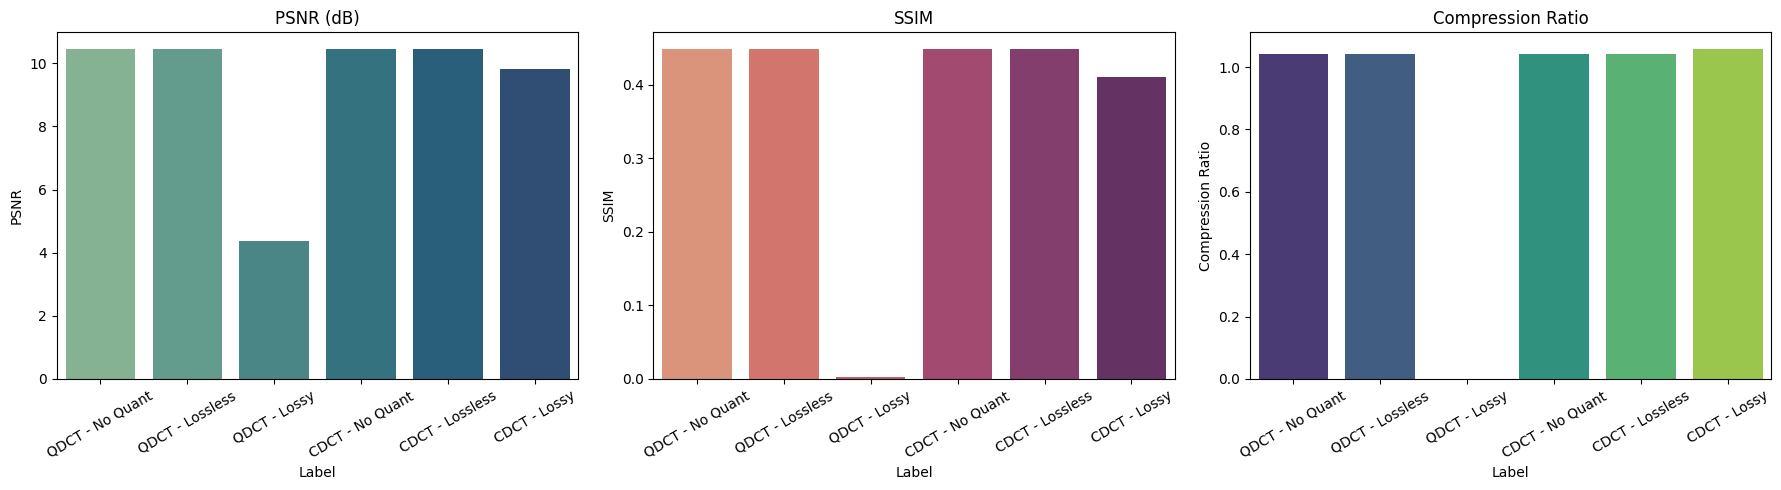

In [16]:
metrics_df = compute_metrics(images_dict["Original"], images_dict)
metrics_df["Label"] = metrics_df["Image"].map(label_map)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=metrics_df, x="Label", y="PSNR", hue="Label", palette="crest", legend=False)
plt.xticks(rotation=30)
plt.title("PSNR (dB)")

plt.subplot(1, 3, 2)
sns.barplot(data=metrics_df, x="Label", y="SSIM", hue="Label", palette="flare", legend=False)
plt.xticks(rotation=30)
plt.title("SSIM")

plt.subplot(1, 3, 3)
sns.barplot(data=metrics_df, x="Label", y="Compression Ratio", hue="Label", palette="viridis", legend=False)
plt.xticks(rotation=30)
plt.title("Compression Ratio")

plt.tight_layout()
plt.show()


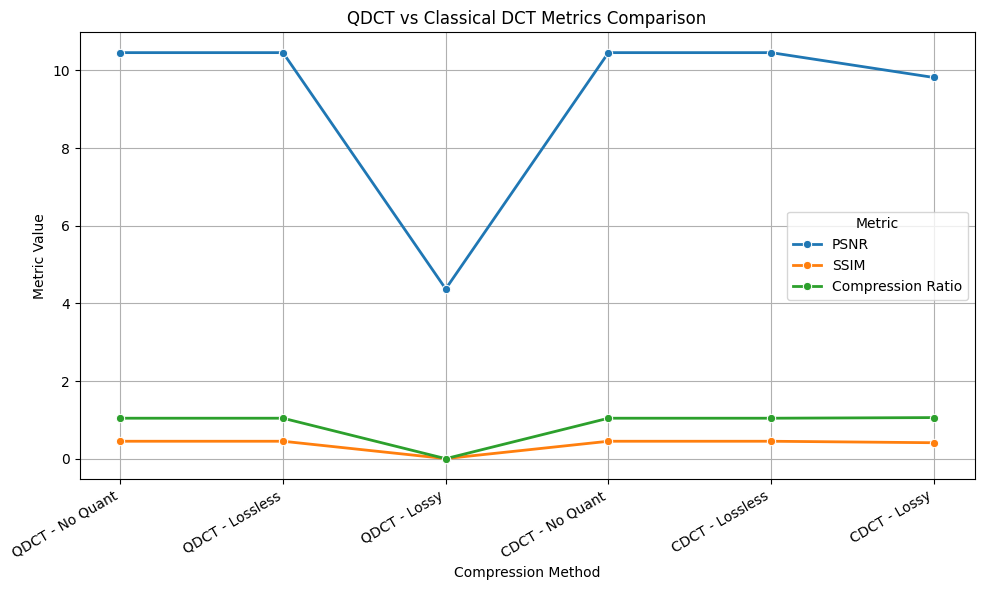

In [17]:
melted = metrics_df.melt(id_vars="Label", 
                         value_vars=["PSNR", "SSIM", "Compression Ratio"],
                         var_name="Metric", 
                         value_name="Value")

plt.figure(figsize=(10, 6))
sns.lineplot(data=melted, x="Label", y="Value", hue="Metric", marker="o", linewidth=2)
plt.xticks(rotation=30, ha='right')
plt.title("QDCT vs Classical DCT Metrics Comparison")
plt.ylabel("Metric Value")
plt.xlabel("Compression Method")
plt.grid(True)
plt.tight_layout()
plt.show()
